In [1]:
import math
import io
import shutil
import os
import sys
from os import path

import numpy as np
import clip
import cv2
from PIL import Image, ImageChops, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms import InterpolationMode

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### DATASET

In [2]:
IMG_DIM = 512
DATASET_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid')
DATASET_DIR

'dataset\\clic2020-professional\\preprocessed\\valid'

In [3]:
def getDataset(image_dir):
    dataset = []
    image_files = [f for f in os.listdir(image_dir) if ".png" in f and path.isfile(os.path.join(image_dir, f))]
    for f in image_files:
        img_id = f.split(".png")[0]
        img_path = path.join(image_dir, f)
        semantics = {
            "object": [],
            "detail": [],
            "summary": ""
        }
        semantics_path = path.join(image_dir, f"{img_id}.semantic.txt")
        with open(semantics_path, "r") as semantic_f:
            lines = semantic_f.read().split('\n')
            semantics["object"] += lines[0:3]
            semantics["detail"] += lines[3:6]
            semantics["summary"] = str(lines[6])
        data = {
            'image_path': img_path,
            'image_name': img_id,
            'semantics': semantics
        }
        dataset.append(data)
    return dataset

dataset = getDataset(DATASET_DIR)
dataset[0]

{'image_path': 'dataset\\clic2020-professional\\preprocessed\\valid\\alberto-montalesi-176097.png',
 'image_name': 'alberto-montalesi-176097',
 'semantics': {'object': ['Large Jellyfish',
   'Cluster of Small Jellyfish',
   'Floating Particles'],
  'detail': ['Predominant, translucent with white spots, tentacles.',
   'Numerous smaller jellyfish, mostly transparent.',
   'Tiny, specklike debris suspended in water.'],
  'summary': 'This image captures a mesmerizing scene underwater, featuring a larger jellyfish with distinctive white spots and flowing tentacles, surrounded by numerous smaller jellyfish and floating particles, all set against a deep blue backdrop.'}}

### CLIP

In [4]:
MAP_DIM = 8 # an image will be splitted into N x N patches
CLIP_THRESHOLD = 0.24

In [7]:
print(f"Clip available variants: {clip.available_models()}")
CLIP_MODEL_CHOICE = "ViT-B/16"

clip_model, clip_preprocess = clip.load(CLIP_MODEL_CHOICE, device=device)
# seg_model, preprocess = clip.load("CS-ViT-B/16", device=device)
clip_model.eval()

total_params = sum(p.numel() for p in clip_model.parameters())
print(f"{CLIP_MODEL_CHOICE}: {total_params} parameters")

Clip available variants: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
ViT-B/16: 149620737 parameters


In [11]:
from helpers.clip import clip_get_similarity_map, split_image_into_patches, overlay_mask_on_image
for i, data in enumerate(tqdm(dataset)):
    img = Image.open(data['image_path']).convert('RGB')
    obj_mask = clip_get_similarity_map(clip_model, clip_preprocess, img, data['semantics']['object'], MAP_DIM, threshold=CLIP_THRESHOLD)

    mask_name = f"{data['image_name']}.dim-{MAP_DIM}.mask.t{int(CLIP_THRESHOLD*100)}.npy"
    np.save(path.join(DATASET_DIR, mask_name), obj_mask.numpy())

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:55<00:00,  1.36s/it]


### CLIP: MultiResolution Test

In [4]:
IMG_DIM = 512
DATASET_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'test')
DATASET_DIR

'dataset\\clic2020-professional\\preprocessed\\test'

In [5]:
dataset = getDataset(DATASET_DIR)
dataset[0]

{'image_path': 'dataset\\clic2020-professional\\preprocessed\\test\\01443654fdc57490d5c2d8b0fd9e065b.png',
 'image_name': '01443654fdc57490d5c2d8b0fd9e065b',
 'semantics': {'object': ['Surfer', 'Surfboard', 'Pier'],
  'detail': ['Young male running on beach, holding surfboard.',
   'White surfboard balanced in surfer’s hand, slim design.',
   'Wooden pier extending into the sea, shadowed by sunlight.'],
  'summary': 'The image captures a vibrant moment on a sunny beach where a young male surfer, dressed in a black wetsuit, runs along the shore. He is holding a white surfboard, poised to join the inviting ocean waves. In the background, a wooden pier stretches into the gleaming sea, adding a picturesque detail to the scene.'}}

In [6]:
for idx, d in enumerate(dataset):
    if d['image_name'] == 'dcb535d6f56922f8d54778b046310443':
        print(idx)

215


In [7]:
demo_img_d = dataset[215]
demo_img_d

{'image_path': 'dataset\\clic2020-professional\\preprocessed\\test\\dcb535d6f56922f8d54778b046310443.png',
 'image_name': 'dcb535d6f56922f8d54778b046310443',
 'semantics': {'object': ['Mountain peaks',
   'Yellow wildflowers',
   'Walking trails'],
  'detail': ['Sharp, towering mountain peaks under a cloudy sky.',
   'Bright yellow wildflowers in the foreground.',
   'Dirt trails with people walking on a hillside'],
  'summary': 'A vibrant and dynamic landscape featuring sharp, majestic mountain peaks juxtaposed against a foreground of vivid yellow wildflowers. A scene of natural beauty where people wander trails across a rugged hillside, under a partly cloudy sky, illustrating a serene yet adventurous setting.'}}

In [8]:
CLIP_MODEL_CHOICE = "ViT-B/16"

clip_model, clip_preprocess = clip.load(CLIP_MODEL_CHOICE, device=device)
# seg_model, preprocess = clip.load("CS-ViT-B/16", device=device)
_ = clip_model.eval()

In [9]:
from helpers.clip import clip_get_similarity_map, split_image_into_patches, overlay_mask_on_image

Score of matched patches: Avg=0.2646484375, Min=0.25341796875, Median=0.2601318359375
Object: Mountain peaks


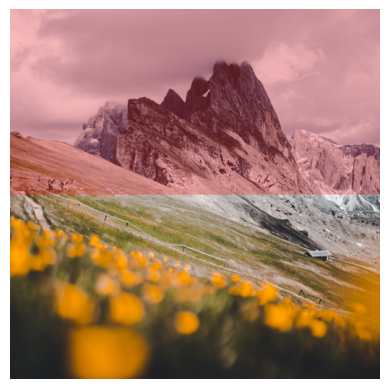

Object: Yellow wildflowers


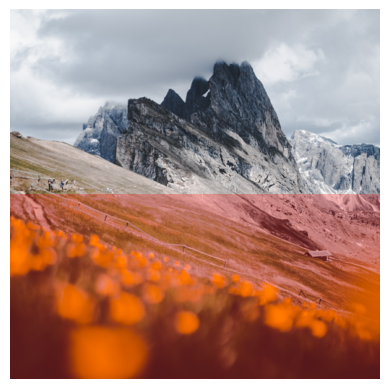

Object: Walking trails


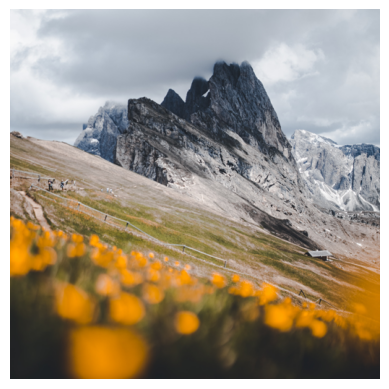

Object: 


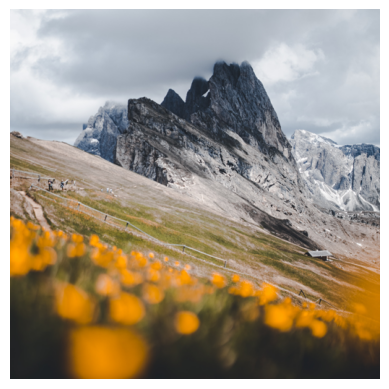

In [15]:
MAP_DIM = 2
img = Image.open(demo_img_d['image_path']).convert('RGB')
_ = clip_get_similarity_map(clip_model, clip_preprocess, img, demo_img_d['semantics']['object'], MAP_DIM, threshold=False, debug=True)

### CLIPSeg: Improved Object Segmentation

In [13]:
# Wrap it as a function
import matplotlib.pyplot as plt
import torch
from PIL import Image
import requests
from os import path
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import cv2

# returns: numpy 2d-array
def zeroShotSegmentation(processor, model, image, text, output_size=512):
    inputs = processor(text=[text], images=[image], padding="max_length", return_tensors="pt").to(device)
    with torch.no_grad():
      outputs = model(**inputs)
    preds = outputs.logits
    mask = torch.sigmoid(preds).cpu().numpy()
    upscaled_mask = cv2.resize(mask, (output_size, output_size), interpolation=cv2.INTER_LINEAR)
    return upscaled_mask

In [7]:
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

In [15]:
for i, data in enumerate(tqdm(dataset)):
    img = Image.open(data['image_path']).convert('RGB')
    object_name = "pancakes"
    masks = np.zeros((len(data['semantics']['object']),IMG_DIM, IMG_DIM))
    for j, obj in enumerate(data['semantics']['object']):
        m = zeroShotSegmentation(clipseg_processor, clipseg_model , img, obj, output_size=IMG_DIM)
        masks[j] = m
    mask_name = f"{data['image_name']}.mask.clipseg.npy"
    np.save(path.join(DATASET_DIR, mask_name), masks)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:10<00:00,  3.96it/s]


### Pixel Pattern Encoder

In [4]:
from compressai.zoo import cheng2020_attn
from torchvision import transforms
from pytorch_msssim import ms_ssim

In [93]:
VAE_QUALITY = 6

In [94]:
VAE_model = cheng2020_attn(quality=VAE_QUALITY, pretrained=True).eval().to(device)

In [95]:
sample_dir = './samples'
image_name = 'dcb535d6f56922f8d54778b046310443'
sample_image = f'{image_name}.png'

img = Image.open(path.join(sample_dir, sample_image)).convert('RGB')
x = transforms.ToTensor()(img).unsqueeze(0).to(device)
output = None
with torch.no_grad():
    output = VAE_model(x)
    output['x_hat'].clamp_(0, 1)

reconstruction = transforms.ToPILImage()(output['x_hat'].squeeze())
# reconstruction.save(f'{image_name}.re_q{VAE_QUALITY}.png')
mse = torch.mean((output['x_hat'] - x).abs(), axis=1).squeeze()

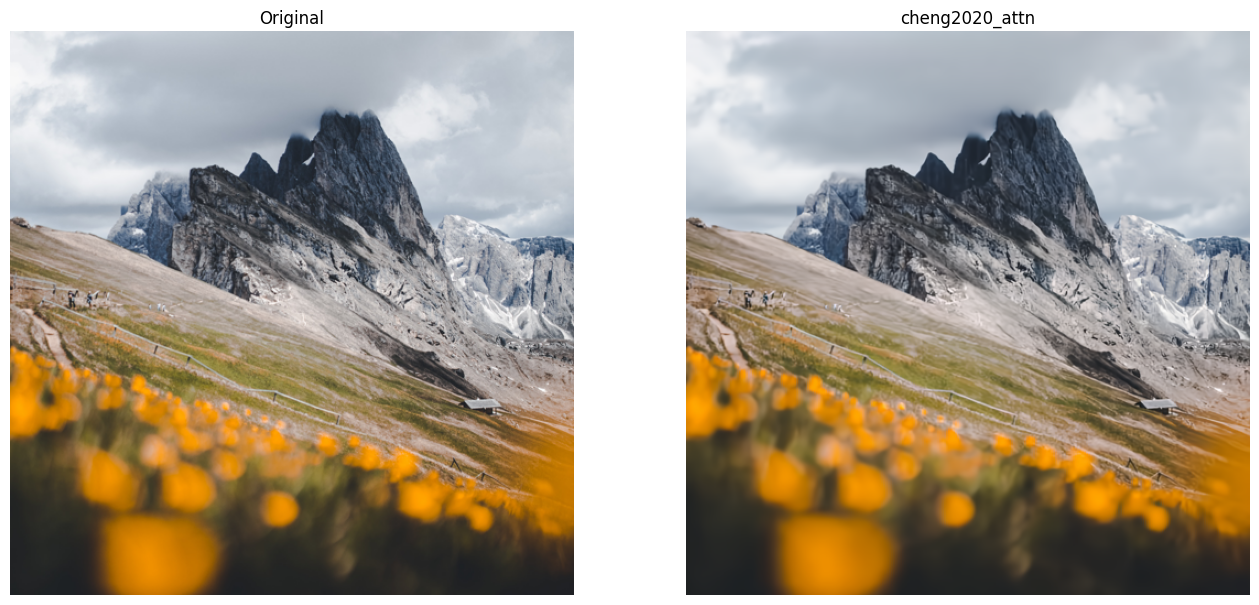

In [96]:
%matplotlib inline
fix, axes = plt.subplots(1, 2, figsize=(16, 12))
for ax in axes.ravel():
    ax.axis('off')
   
axes.ravel()[0].imshow(img)
axes.ravel()[0].title.set_text('Original')
axes.ravel()[1].imshow(reconstruction)
axes.ravel()[1].title.set_text('cheng2020_attn')

plt.show()

In [97]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels) for likelihoods in out_net['likelihoods'].values()).item()

https://github.com/InterDigitalInc/CompressAI/issues/265  
demonstrates how to calculate bpp

In [108]:
vae_psnr = compute_psnr(x, output["x_hat"])
vae_ms_ssim = compute_msssim(x, output["x_hat"])
bpp = compute_bpp(output)
print(f"PSNR: {vae_psnr}, MS-SSIM: {vae_ms_ssim}, BPP: {bpp}")

PSNR: 37.42360927149549, MS-SSIM: 0.9944011569023132, BPP: 0.7005540728569031


### Diffusion Model

In [4]:
# Add the root directory of the repository to the Python path
repo_root = os.path.abspath(os.path.join('DiffBIR'))
sys.path.insert(0, repo_root)
from DiffBIR.sr_helper import sr_pipeline

use sdp attention as default
keep default attention mode


In [5]:
# modify dataset image dir
# VAE_IMG_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_ft_e349_d256') # BPP: 0.01263
# VAE_IMG_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_ft_e239_lambda45e-4_cheng-attn_d256') # BPP: 0.02228
# VAE_IMG_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_ft_e97_lambda18e-3_cheng-attn_d256') # BPP: 0.04836
# VAE_IMG_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_pixpat_q3_d256') # BPP:  0.077
VAE_IMG_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_ft_e349_d256') # BPP: 0.01263
SEMANTIC_DIR = path.abspath(path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid'))
# RESULT_DIR = path.abspath(path.join('results', 'valid_ft_e97_lambda18e-3_clippatch'))
RESULT_DIR = path.abspath(path.join('results', 'valid_ft_e349_d256'))
for data in dataset:
    data["image_path"] = path.abspath(path.join(VAE_IMG_DIR, path.basename(data["image_path"])))

In [ ]:
# sr_pipeline(dataset, SEMANTIC_DIR, RESULT_DIR, steps=50, upscale=2, cfg=4)
sr_pipeline(dataset, SEMANTIC_DIR, RESULT_DIR, steps=15, upscale=2, cfg=4, reproduce=True)

In [ ]:
VAE_IMG_DIR = path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid_ft_e349_d256') # BPP: 0.01263
SEMANTIC_DIR = path.abspath(path.join('dataset', 'clic2020-professional', 'preprocessed', 'valid'))
# RESULT_DIR = path.abspath(path.join('results', 'valid_ft_e97_lambda18e-3_clippatch'))
RESULT_DIR = path.abspath(path.join('results', 'valid_ft_e349_d256_2'))
for data in dataset:
    data["image_path"] = path.abspath(path.join(VAE_IMG_DIR, path.basename(data["image_path"])))

sr_pipeline(dataset, SEMANTIC_DIR, RESULT_DIR, steps=30, upscale=2, cfg=4, reproduce=False)